# Caso práctico: Random Forest

En este caso de uso práctico se pretende resolver un problema de detección de malware en disitivos Android mediante el anaálsis de tráfico de red que genera el dispostivo mediante el uso de conjunto de árboles de desición.

## Description

The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behaviour to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. 

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1,900 applications with the following three categories:

**1. Adware (250 apps)**
* **Airpush**: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
* **Dowgin**: Designed as an advertisement library that can also steal the user’s information.
* **Kemoge**: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
* **Mobidash**: Designed to display ads and to compromise user’s personal information.
* **Shuanet**: Similar to Kemoge, Shuanet is also designed to take over a user’s device.

**2. General Malware (150 apps)**
* **AVpass**: Designed to be distributed in the guise of a Clock app.
* **FakeAV**: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
* **FakeFlash/FakePlayer**: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
* **GGtracker**: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
* **Penetho**: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

**3. Benign (1,500 apps)**
* 2015 GooglePlay market (top free popular and top free new)
* 2016 GooglePlay market (top free popular and top free new)

## Imports

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from pandas import DataFrame

### Funciones Auxiliares

In [78]:
# Construcción de una función que realice al particionado completo 

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat) 
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [79]:
# Separa el dataframe de label_name y se la genera en otro datraframe (y)

def remove_labels(df, label_name):
    X = df.drop(label_name, axis = 1)
    y = df[label_name].copy()
    return(X, y)

In [80]:
# permite comparar el rendimient con una una preparación y sin preparación del modelo de aprendizaje
# metric es la metrica de comparación

def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, ' Whithout preparation: ', metric(y_pred, y, average ='weighted'))
    print(metric.__name__, ' Whith preparation: ', metric(y_prep_pred, y_prep, average ='weighted'))

### 1.- Lectura del DataSet

In [81]:
df = pd.read_csv('data/TotalFeatures-ISCXFlowMeter.csv')

### 2. Visualización del DataSet

In [82]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [83]:
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,3.159770e+05,315977.000000,315977.000000,3.159770e+05,3.159770e+05,315977.000000,315977.000000,315977.000000,315977.000000,315977.000000,...,3.159770e+05,3.159770e+05,3.159770e+05,3.159770e+05,315977.000000,3.159770e+05,3.159770e+05,315977.000000,315977.000000,315977.000000
mean,1.456170e+07,5.408305,7.969283,7.828554e+02,9.656793e+03,211.070894,34.541739,302.603449,131.493068,238.203467,...,1.350228e+07,1.371291e+07,1.398411e+07,2.838006e+05,2.268228,7.438681e+05,2.503484e+05,7.563826,5.408220,14.738655
std,1.868214e+08,193.223225,359.298667,6.339165e+04,4.977524e+05,179.564073,80.473280,254.311154,321.155330,173.115136,...,1.866690e+08,1.866514e+08,1.867661e+08,4.412134e+06,0.973226,1.563906e+06,6.027566e+05,357.928135,193.223228,15.526032
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,1.000000,0.000000,8.300000e+01,0.000000e+00,52.000000,-1.000000,60.000000,-1.000000,58.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.000000,0.000000
50%,2.000000e+00,1.000000,0.000000,3.650000e+02,0.000000e+00,71.000000,-1.000000,365.000000,-1.000000,231.142857,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.000000,0.000000
75%,1.914960e+05,2.000000,1.000000,4.220000e+02,1.120000e+02,420.000000,52.000000,422.000000,60.000000,420.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,9.676800e+04,1.024000e+04,1.000000,2.000000,32.000000
max,4.431076e+10,48255.000000,74768.000000,3.314682e+07,1.039222e+08,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,5.350000e+08,62.000000,4.194240e+06,4.194240e+06,74524.000000,48255.000000,44.000000


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315977 entries, 0 to 315976
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 315977 non-null  int64  
 1   total_fpackets           315977 non-null  int64  
 2   total_bpackets           315977 non-null  int64  
 3   total_fpktl              315977 non-null  int64  
 4   total_bpktl              315977 non-null  int64  
 5   min_fpktl                315977 non-null  int64  
 6   min_bpktl                315977 non-null  int64  
 7   max_fpktl                315977 non-null  int64  
 8   max_bpktl                315977 non-null  int64  
 9   mean_fpktl               315977 non-null  float64
 10  mean_bpktl               315977 non-null  float64
 11  std_fpktl                315977 non-null  float64
 12  std_bpktl                315977 non-null  float64
 13  total_fiat               315977 non-null  int64  
 14  tota

In [85]:
print('Longitud del DataSet: ', len(df))
print('Número de características: ', len(df.columns))

Longitud del DataSet:  315977
Número de características:  80


In [86]:
df['calss'].value_counts()

calss
benign    234706
asware     81271
Name: count, dtype: int64

#### Buscando correlaciones

In [87]:
# Transformar la variable de salida a númerica para calcular correlaciones

X = df.copy()
X['calss'] = X['calss'].factorize()[0]
corr_matrix = X.corr()
corr_matrix['calss'].sort_values(ascending=False)

calss                   1.000000
min_seg_size_forward    0.457317
flow_fin                0.387507
std_flowpktl            0.278275
std_fpktl               0.259504
                          ...   
furg_cnt                     NaN
burg_cnt                     NaN
flow_urg                     NaN
flow_cwr                     NaN
flow_ece                     NaN
Name: calss, Length: 80, dtype: float64

In [88]:
X.corr()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004517,0.004147,0.002075,0.003897,-0.066954,-0.012567,-0.007281,0.041479,-0.053719,...,0.999497,0.999808,0.036684,0.049606,0.030447,0.023977,0.004016,0.004517,0.077838,0.064202
total_fpackets,0.004517,1.000000,0.953720,0.359621,0.942292,-0.020486,0.005026,0.011712,0.075881,-0.015110,...,0.002247,0.002696,0.016746,0.002544,0.044397,0.051309,0.941149,1.000000,0.016838,0.024567
total_bpackets,0.004147,0.953720,1.000000,0.183186,0.998343,-0.020300,0.005673,0.007768,0.079682,-0.020334,...,0.001866,0.002338,0.013536,-0.000924,0.044637,0.052520,0.998339,0.953720,0.015888,0.025095
total_fpktl,0.002075,0.359621,0.183186,1.000000,0.128019,-0.004458,0.001082,0.020739,0.023823,0.017565,...,0.000774,0.001272,0.027514,0.002023,0.014385,0.016582,0.126414,0.359621,0.006321,0.003371
total_bpktl,0.003897,0.942292,0.998343,0.128019,1.000000,-0.017879,0.004668,0.004934,0.075286,-0.020192,...,0.001711,0.002144,0.011390,-0.000443,0.040573,0.048294,0.999901,0.942292,0.013407,0.024387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Init_Win_bytes_backward,0.023977,0.051309,0.052520,0.016582,0.048294,-0.370339,0.087174,0.325421,0.540082,-0.168895,...,0.021170,0.022725,0.082286,-0.106925,0.875031,1.000000,0.051163,0.051309,0.430935,0.163992
RRT_samples_clnt,0.004016,0.941149,0.998339,0.126414,0.999901,-0.019430,0.004885,0.006538,0.078025,-0.020928,...,0.001800,0.002244,0.011893,-0.000805,0.043376,0.051163,1.000000,0.941149,0.015209,0.024902
Act_data_pkt_forward,0.004517,1.000000,0.953720,0.359621,0.942292,-0.020486,0.005026,0.011712,0.075881,-0.015109,...,0.002247,0.002696,0.016746,0.002544,0.044397,0.051309,0.941149,1.000000,0.016838,0.024567
min_seg_size_forward,0.077838,0.016838,0.015888,0.006321,0.013407,-0.776141,-0.021175,-0.177927,0.307402,-0.644415,...,0.075333,0.076438,0.054241,0.153990,0.475394,0.430935,0.015209,0.016838,1.000000,0.457317


In [89]:
# Se puede llegar a valorar quedarse con aquellas que tienen mayor correlación

corr_matrix[corr_matrix['calss'] > 0.05]

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004517,0.004147,0.002075,0.003897,-0.066954,-0.012567,-0.007281,0.041479,-0.053719,...,0.999497,0.999808,0.036684,0.049606,0.030447,0.023977,0.004016,0.004517,0.077838,0.064202
min_bpktl,-0.012567,0.005026,0.005673,0.001082,0.004668,-0.361987,1.000000,-0.171617,0.327728,-0.340474,...,-0.013218,-0.012982,0.014257,-0.076617,0.070376,0.087174,0.004885,0.005026,-0.021175,0.130988
max_bpktl,0.041479,0.075881,0.079682,0.023823,0.075286,-0.359280,0.327728,0.407991,1.000000,-0.135242,...,0.037589,0.039757,0.113988,-0.074493,0.578930,0.540082,0.078025,0.075881,0.307402,0.203963
mean_bpktl,0.027336,0.126217,0.139972,0.022990,0.136507,-0.372973,0.519487,0.265675,0.899629,-0.208086,...,0.023720,0.025687,0.101588,-0.075894,0.459869,0.449890,0.138962,0.126217,0.234706,0.200230
std_fpktl,0.036474,0.006447,0.001437,0.011378,-0.002059,-0.328360,0.079967,0.716075,0.589808,0.091723,...,0.032430,0.034524,0.107709,-0.013057,0.605966,0.565590,0.000250,0.006447,0.377975,0.259504
std_bpktl,0.045988,0.012551,0.008839,0.007738,0.005089,-0.287357,0.074957,0.472625,0.938456,-0.038008,...,0.042736,0.044622,0.101500,-0.050538,0.573083,0.516394,0.007711,0.012551,0.335010,0.177074
total_fiat,0.966694,0.001800,0.001693,0.000565,0.001710,-0.051193,-0.017518,-0.035286,0.000326,-0.051141,...,0.966856,0.966584,0.012194,0.055247,-0.000279,-0.009262,0.001682,0.001800,0.059753,0.058192
min_fiat,0.793549,-0.000953,-0.001197,-0.000568,-0.001049,-0.046107,-0.023070,-0.051804,-0.022099,-0.056141,...,0.794348,0.793928,-0.003354,0.040570,-0.012272,-0.022377,-0.001142,-0.000953,0.054007,0.066316
max_fiat,0.966527,0.000056,-0.000057,-0.000218,0.000010,-0.049600,-0.017503,-0.035448,-0.000843,-0.050151,...,0.967108,0.966757,0.009521,0.046177,-0.001732,-0.010160,-0.000035,0.000056,0.058450,0.056409
mean_fiat,0.929561,-0.000926,-0.001215,-0.000534,-0.001081,-0.048105,-0.021849,-0.048147,-0.017299,-0.054925,...,0.930434,0.929918,-0.001574,0.044489,-0.010465,-0.020545,-0.001166,-0.000926,0.056502,0.062523


### 3. Divisón del DataSet

In [90]:
train_set, val_set, test_set = train_val_test_split(X)

In [91]:
X_train, y_train = remove_labels(train_set, 'calss')
X_val, y_val = remove_labels(val_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

### 4. Escalado del DataSet

Es importante  comprender que los árboles de desición son algoritmos que **No requieren demasiada preparación de los datos** concretamente, no requieren la realización o escalado o normalización. En este ejercicio se va a realizar escalado al DataSet y se van a comprar los resultados con el DataSet sin escalar. De está manera se demuestra como aplicar preprocesamientos de como el escalado puede llegar a afectar al rendimiento del modelo.

In [92]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [93]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [94]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val)

In [95]:
# Transformar el DataSet a un DataFrame de pandas

X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
116976,1.113878,12.0,12.0,5.274336,46.044643,-0.051630,1.0,1.160221,22.803279,-0.181015,...,0.0,0.0,0.0,0.0,0.0,43.343254,265.849136,10.0,12.0,1.000
261432,-0.000011,0.0,0.0,-0.923304,0.000000,-0.051630,0.0,-0.864641,0.000000,-0.494870,...,0.0,0.0,0.0,0.0,0.0,0.050926,0.000000,0.0,0.0,1.000
293551,2.442994,1.0,0.0,-0.769912,0.000000,-0.051630,0.0,-0.864641,0.000000,-0.494870,...,0.0,0.0,0.0,0.0,1.0,0.905423,0.000000,0.0,1.0,1.000
296426,0.000000,1.0,0.0,-0.840708,0.000000,-0.084239,0.0,-0.897790,0.000000,-0.528019,...,0.0,0.0,0.0,0.0,1.0,0.916667,0.000000,0.0,1.0,0.625
243164,-0.000011,0.0,0.0,0.209440,0.000000,0.991848,0.0,0.196133,0.000000,0.565904,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000
183278,1084.205202,1.0,0.0,-0.734513,0.000000,-0.051630,0.0,-0.831492,0.000000,-0.478295,...,199656662.0,200000000.0,199656662.0,0.0,1.0,0.962963,0.000000,0.0,1.0,1.000
20404,0.412104,2.0,3.0,-0.286136,1.464286,-0.051630,1.0,-0.577348,1.000000,-0.391739,...,0.0,0.0,0.0,0.0,0.0,43.343254,167.777463,2.0,2.0,1.000
25781,-0.000011,0.0,0.0,0.162242,0.000000,0.948370,0.0,0.151934,0.000000,0.521705,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000
130727,-0.000011,0.0,0.0,0.126844,0.000000,0.915761,0.0,0.118785,0.000000,0.488556,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000
230506,0.038164,0.0,1.0,-0.923304,0.464286,-0.051630,1.0,-0.864641,0.868852,-0.494870,...,0.0,0.0,0.0,0.0,0.0,0.157407,8.555512,1.0,0.0,1.000


In [96]:
X_train_scaled.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,189586.000000,189586.000000,189586.00000,189586.000000,189586.000000,189586.000000,189586.000000,189586.000000,189586.000000,189586.000000,...,1.895860e+05,1.895860e+05,1.895860e+05,1.895860e+05,189586.000000,189586.000000,189586.000000,189586.000000,189586.000000,189586.000000
mean,78.921024,3.723978,6.92318,0.917063,73.600225,0.380534,0.671847,-0.172447,2.171021,0.019408,...,1.347612e+07,1.368824e+07,1.395885e+07,2.856117e+05,0.268095,7.721182,24.527602,6.550906,3.723893,0.460780
std,1007.970883,148.786809,308.66512,85.035224,3821.961310,0.488325,1.519151,0.702196,5.261528,0.478257,...,1.854604e+08,1.854415e+08,1.855628e+08,4.523819e+06,0.988823,16.189533,58.886799,308.165434,148.786811,0.485205
min,-0.000011,-1.000000,0.00000,-1.076696,0.000000,-0.195652,0.000000,-1.011050,0.000000,-0.638516,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-0.000010,0.000000,0.000000,-1.000000,0.000000
25%,-0.000011,0.000000,0.00000,-0.831858,0.000000,-0.051630,0.000000,-0.842541,0.000000,-0.478295,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.999989,1.000000,1.00000,0.168142,1.000000,0.948370,1.000000,0.157459,1.000000,0.521705,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,184978.135045,23124.000000,44461.00000,36011.873156,551500.866071,3.584239,26.245283,2.831492,22.803279,3.201263,...,3.406373e+10,3.410000e+10,3.406373e+10,5.350000e+08,60.000000,43.343254,409.553852,44309.000000,23124.000000,1.375000


### 5. Random Forest

 1. Modelo de entrenamiento escalado y sin escalar
 2. Comparación
 3. Predicción de datos de validación 
 4. Comparar los resultados con escalar y escalado
 5. Regresión Forest

In [97]:
from sklearn.tree import DecisionTreeClassifier

# modelo entrenado con el DataSet sin escalar
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [98]:
# modelo entrenado con el DataSet escalado

clf_tree_scaled = DecisionTreeClassifier(random_state=42)
clf_tree_scaled.fit(X_train_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [99]:
# Predecir el DataSet de entrenamiento

y_train_pred = clf_tree.predict(X_train)
y_train_prep_pred = clf_tree_scaled.predict(X_train_scaled)

# Comparacion de los resultados del DataSet escalado y sin escaar
evaluate_result(y_train_pred, y_train, y_train_prep_pred,y_train, f1_score)

f1_score  Whithout preparation:  0.9909154075293094
f1_score  Whith preparation:  0.9909154075293094


In [100]:
# Predecir con el DataSet de validación

y_val_pred = clf_tree.predict(X_val) # modelo sin escalar
y_val_prep_pred = clf_tree_scaled.predict(X_val_scaled)

# Comparar los resultados entre scalado y sin escalar
evaluate_result(y_val_pred, y_val, y_val_prep_pred, y_val, f1_score)

f1_score  Whithout preparation:  0.9627588995058699
f1_score  Whith preparation:  0.9258379032864015


/home/silver/Documentos/GitHub/SVM/plyf/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# 6.- Regresión Forest
## Tarea
- Hacer el tema de regresion para random forest, desplegado (DJango) se revisara desde GIT.
- Investigar como validar codigo en git.
- Seleccionar cantidad de datos que se entrenan.

In [101]:
# Random Regresion Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X_train_reduced = X_train[['min_flowpktl', 'flow_fin']]

In [102]:
reg_tree_reduced = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

reg_tree_reduced.fit(X_train_reduced, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


/home/silver/Documentos/GitHub/SVM/plyf/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


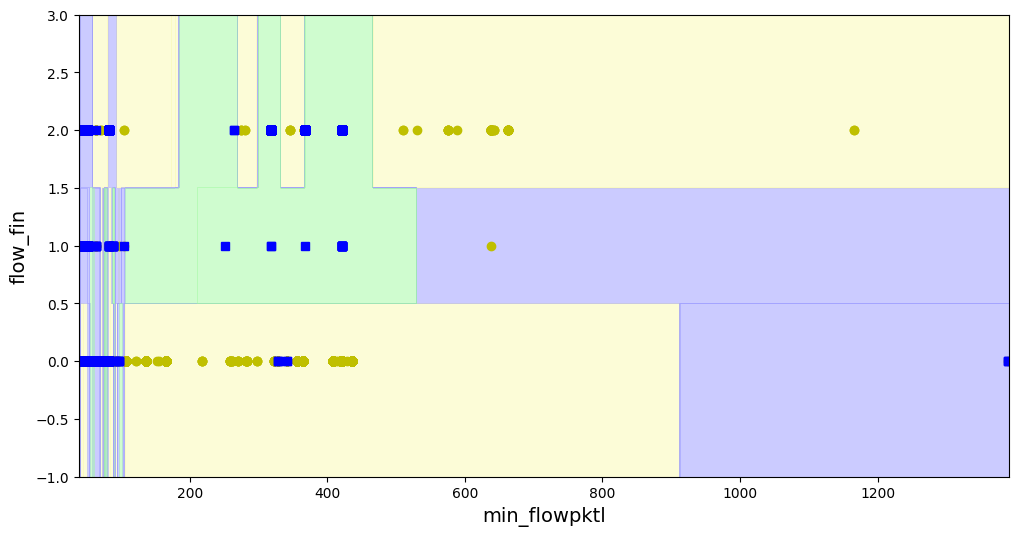

In [103]:
# Representación del limite de decisión del árbol de regresión

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_boundary(reg, X, y, plot_training=True, resolution=1000):
    # Obtener rangos de los datos
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    # Crear una malla de puntos (meshgrid)
    x1, x2 = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution)
    )

    # Crear la matriz de características para las predicciones
    X_new = np.c_[x1.ravel(), x2.ravel()]

    # Predecir los valores para cada punto en la malla
    y_pred = reg.predict(X_new).reshape(x1.shape)

    # Graficar el límite de decisión
    custom_cmap = ListedColormap(['#FAFAB0', '#9898FF', '#A0FAA0'])
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.5)

    # Graficar los datos de entrenamiento
    if plot_training:
        plt.plot(X[:,0][y==0], X[:,1][y==0], 'yo', label='normal')
        plt.plot(X[:,0][y==1], X[:,1][y==1], 'bs', label='adware')
        plt.plot(X[:,0][y==2], X[:,1][y==2], 'g^', label='malware')
        plt.axis([mins[0], maxs[0], mins[1], maxs[1]])
    plt.xlabel('min_flowpktl', fontsize = 14)
    plt.ylabel('flow_fin', fontsize = 14, )

plt.figure(figsize=(12,6))
plot_decision_boundary(reg_tree_reduced, X_train_reduced.values, y_train)
plt.show()

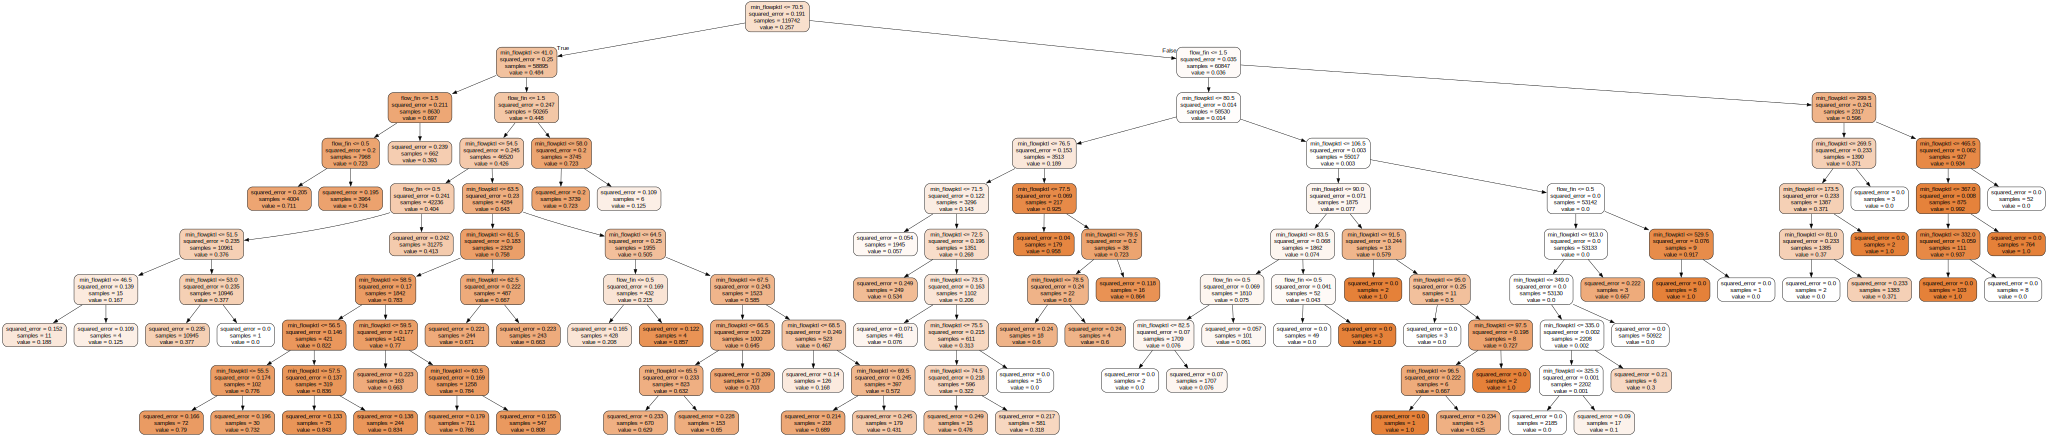

In [105]:
# Visualizar el Arbol de regresión
from graphviz import Source
from sklearn.tree import export_graphviz
import os

# Guardar el árbol de decisión en un archivo .dot
tree_to_visualize = reg_tree_reduced.estimators_[0]

export_graphviz(
    tree_to_visualize,
    out_file='android_malware.dot',
    feature_names = X_train_reduced.columns,
    class_names = ['benign', 'adware', 'malware'],
    rounded=True,
    filled=True,
)

Source.from_file('android_malware.dot')

NameError: name 'reg_tree_reduced' is not defined